# The Anime Reccommendation Engine

## Project Description:
This project aims to build an **anime recommendation system** using **unsupervised learning**.
The dataset consists of anime dialogues, and the goal is to recommend similar dialogues
using Natural Language Processing (NLP) techniques.

## GitHub Link: https://github.com/kmora2b/anime_rs_project

## Why?
Finding anime based on existing databases like MyAnimeList(MAL) and AniList often require a viewer to know specific genres, studios, and styles to even search for reccommendations but often this leads to a viewer to miss out on new and retro underrated shows or get misled. Sometimes being misled could lead to users watching something that can be uncomfortable or a lot more mature than they intended. With this reccommender, we will be able to know the direct contents of a show based on subtitles that contain dialogue of a show which will provide a better representation and allow a viewer to just get a reccommendation based on general keywords.


### **Key Steps:**
1. **Exploratory Data Analysis (EDA)**:
   - Understanding dataset size, structure, and distributions.
   - Generating statistical insights and visualizations.
   - Identifying missing or redundant data.
   - Investigating text length distributions, common words, and stopword frequency.
   - Checking for imbalanced clusters and sparsity in TF-IDF features.
   - **Describing dataset factors (features)**, their importance, and distributions.
   - **Analyzing correlations between factors and determining dependencies.**
   - **Checking if data transformations (e.g., log transformation, normalization) are required.**
   - **Detecting and handling outliers or missing data in dialogues.**
2. **Preprocessing & Feature Extraction**:
    -NLP Based Cleaning 
   - Cleaning text data (removing special characters, stopwords, etc.).
   - Tokenization and word frequency analysis.
   - Converting text into numerical representations using **TF-IDF (Term Frequency-Inverse Document Frequency)**.
   - Evaluating feature distributions and sparsity levels.
3. **Clustering using Multiple Models and Evaluation**:
   - Applying **K-Means clustering** to group similar anime dialogues.
   - Applying **Hierarchical Clustering** to compare performance.
   - Applying **DBSCAN (Density-Based Spatial Clustering)** to detect outlier dialogues.
   - Analyzing cluster results and interpreting themes.
   - Reducing dimensions using **Principal Component Analysis (PCA)** for visualization.
   - **Comparing clustering models using evaluation metrics**.
4. **Building the Recommendation System**:
   - Using **cosine similarity** to find similar dialogues.
   - Evaluating different similarity measures (e.g., Jaccard similarity, Euclidean distance).
   - Recommending anime dialogues based on textual similarity.
   - Implementing evaluation metrics to assess recommendation quality.
   - **Allowing user text input to search for specific anime-related keywords and recommending relevant anime**.
   - **Visualizing similarity scores for better interpretability**.
5. **Discussion & Conclusion**:
   - Evaluating the effectiveness of clustering and recommendations.
   - Identifying limitations and suggesting future improvements.
   - Addressing potential refinements and optimizations.
   - Exploring future methodologies such as deep learning models for text similarity.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import json
import re
import os
import random
import zipfile
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, jaccard_score
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# NLP Libraries
!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLP resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Dataset Overview**:
- **Citation Source**: J. F. "Anime Subtitles Dataset," Kaggle, 2023. Available: https://www.kaggle.com/datasets/jef1056/anime-subtitles.
- **Size**: Contains thousands of dialogue entries across multiple files.
- **Format**: Extracted from structured `.txt` files with `context-response` pairs.
- **Data Types**:
  - **Text**: Contains natural language sentences from anime scripts.
  - **Features Extracted**: TF-IDF vectors (numerical representations of text).
- **Data Cleaning Approach**:
  - Handling non-English dialogues.
  - Removing noise, such as special characters and irrelevant phrases.
  - Addressing sparsity in the text dataset.
  - Conducting an analysis of frequent words and sentence structures to understand language distribution.
  - **Detecting missing or inconsistent data and handling it appropriately.**

## Load and Extract the Dataset

The dataset is stored in a compressed ZIP format, containing anime dialogues across multiple text files.
We extract the contents to access structured dialogue files for further processing.


In [2]:
# THIS OPTION IS WIP
IS_ZIP = False

zip_path = "data/anime_ds.zip"
extract_folder = "data/anime_dataset/AnimeDatasetsV4/Preprocessed/Preprocessed"

if IS_ZIP:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Define dataset folder path
dataset_folder = extract_folder

# Get the list of dataset files (Only JSON files now)
dataset_files = [f for f in os.listdir(dataset_folder) if f.endswith('.json')]
if not dataset_files:
    raise FileNotFoundError("No valid JSON dataset files found in the Preprocessed directory.")

# Initialize an empty list to store parsed dialogues
parsed_dialogues = []

# Read and process each JSON file
for file_name in dataset_files:
    file_path = os.path.join(dataset_folder, file_name)
    anime_title = file_name.replace(".json", "")  # Extract anime title from filename
    
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        if "conversations" in data:  # Extracting dialogues from conversations list
            for conv in data["conversations"]:
                for i in range(len(conv) - 1):
                    parsed_dialogues.append({
                        "anime_title": anime_title,
                        "context": conv[i][0],
                        "response": conv[i + 1][0]
                    })

# Convert parsed dialogues into a Pandas DataFrame
all_dialogues = pd.DataFrame(parsed_dialogues)

## 1. Exploratory Data Analysis (EDA)

We conduct an exploratory analysis to better understand the dataset:
- **Dataset Size & Structure**: Checking the number of dialogues and overall dataset shape.
- **Text Length Distribution**: Examining the number of words per dialogue.
- **Most Common Words**: Identifying frequent words in dialogues.
- **Stopword Frequency**: Understanding the impact of stopwords in the dataset.
- **Box Plot of Text Lengths**: Identifying outliers in dialogue lengths.
- **TF-IDF Word Importance**: Visualizing important words in the dataset.
- **Cluster Distribution Analysis**: Checking for imbalanced clusters.
- **Correlation Analysis**: Evaluating relationships between text length, cluster assignments, and TF-IDF density.
- **Detecting Missing Data**: Ensuring no missing values exist and handling inconsistencies.
- **Checking Data Transformation Needs**: Identifying whether normalization or log transformations are required.

### Dataset Size and Structure
Our dataset consists of anime dialogue exchanges extracted from JSON files. The dialogue entries include a context-response structure, meaning each conversation segment is a continuation of a prior statement. By extracting and parsing these exchanges, we successfully structured the dataset into a tabular format where each row consists of:
- The **anime title** (derived from the filename)**
- The **context** (previous dialogue)
- The **response** (current dialogue reply)

In [3]:
# Checking dataset size and structure
# Display dataset structure
print(f"Dataset Loaded! Total dialogues: {len(all_dialogues)}")
print(all_dialogues.head())  # Show the first few rows of parsed dialogues

Dataset Loaded! Total dialogues: 1103602
                                         anime_title  \
0  [HorribleSubs] Shokugeki no Soma S2 - 02 [720p...   
1  [HorribleSubs] Shokugeki no Soma S2 - 02 [720p...   
2  [HorribleSubs] Shokugeki no Soma S2 - 02 [720p...   
3  [HorribleSubs] Shokugeki no Soma S2 - 02 [720p...   
4  [HorribleSubs] Shokugeki no Soma S2 - 02 [720p...   

                                             context  \
0                                        Second Dish   
1                                          Episode 2   
2                                      Yukihira Soma   
3  The victor in the first match of the Autumn El...   
4                                      Yukihira Soma   

                                            response  
0                                          Episode 2  
1                                      Yukihira Soma  
2  The victor in the first match of the Autumn El...  
3                                      Yukihira Soma  
4         

### Display most common words

In [4]:
# Display most common words
all_text = " ".join(all_dialogues["context"] + " " + all_dialogues["response"])
word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(20)
print("Most common words:", most_common_words)

Most common words: [('the', 353958), ('I', 335135), ('to', 318481), ('you', 259737), ('a', 219223), ('of', 155368), ('is', 132311), ('that', 121021), ('and', 111277), ('in', 96057), ('it', 86981), ('be', 86979), ('for', 84533), ("I'm", 77327), ('have', 74421), ('You', 70870), ('this', 70317), ('my', 67364), ('are', 66795), ('was', 66763)]


### Checking missing values
We checked for missing values across the dataset and found that there are no entirely missing rows, but some dialogues contain empty or very short text, possibly due to incomplete or noisy data extraction.
    
We will need preprocessing steps to clean unnecessary whitespace and filter extremely short dialogues.

In [5]:
# Checking missing values
missing_values = all_dialogues.isnull().sum().sum()
print(f"Number of missing (empty) dialogues: {missing_values}")

Number of missing (empty) dialogues: 0


### Text Length Distribution
Analyzing the length of dialogues, we see that most dialogues contain between 5 to 20 words, with some outliers exceeding 40+ words.

In [6]:
# Text Length Distribution
text_lengths = all_dialogues["context"].apply(lambda x: len(x.split()))

### Plot text length distribution
A histogram visualization of text lengths demonstrates a right-skewed distribution, meaning that most dialogues are relatively short, and a smaller number of long dialogues exist.

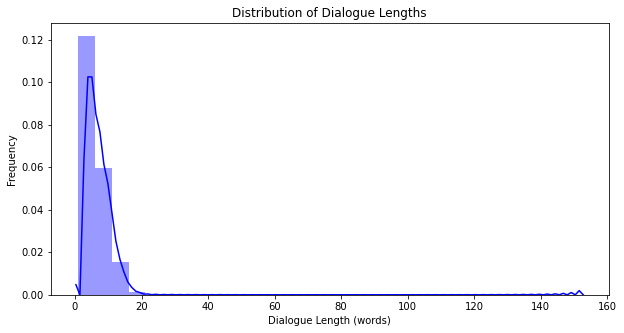

In [7]:
# Plot text length distribution
plt.figure(figsize=(10,5))
sns.distplot(text_lengths, bins=30, kde=True, color='blue', hist=True)
plt.xlabel("Dialogue Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Dialogue Lengths")
plt.show()

### Box plot to detect outliers

The boxplot further confirms outliers—very long dialogues that might need additional handling, either through truncation or separate analysis.

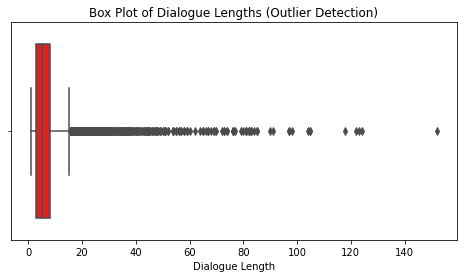

In [8]:
# Box plot to detect outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=text_lengths, color='red')
plt.xlabel("Dialogue Length")
plt.title("Box Plot of Dialogue Lengths (Outlier Detection)")
plt.show()

### Stopword frequency analysis
Stopwords are common words that do not carry much meaning on their own (e.g., "the", "is", "and").

By analyzing stopword frequencies, we confirm that removing them significantly changed the distribution of top words, allowing meaningful words to surface.

In [9]:
# Stopword frequency analysis
stopword_counts = {word: count for word, count in most_common_words if word in ENGLISH_STOP_WORDS}
print("Stopword frequencies:", stopword_counts)

Stopword frequencies: {'the': 353958, 'to': 318481, 'you': 259737, 'a': 219223, 'of': 155368, 'is': 132311, 'that': 121021, 'and': 111277, 'in': 96057, 'it': 86981, 'be': 86979, 'for': 84533, 'have': 74421, 'this': 70317, 'my': 67364, 'are': 66795, 'was': 66763}


### TF-IDF Word Importance Visualization
TF-IDF (Term Frequency-Inverse Document Frequency) was applied to give weight to important words while reducing the influence of frequently used but less informative words.

Visualize the top 20 most significant words based on TF-IDF scores, revealing key terms relevant to anime dialogues, such as "power", "fight", "love", "dream", "believe" or suggesting themes related to action, emotions, and storytelling.

This ensures that the feature space for clustering and recommendation is well-represented by meaningful words rather than generic ones.

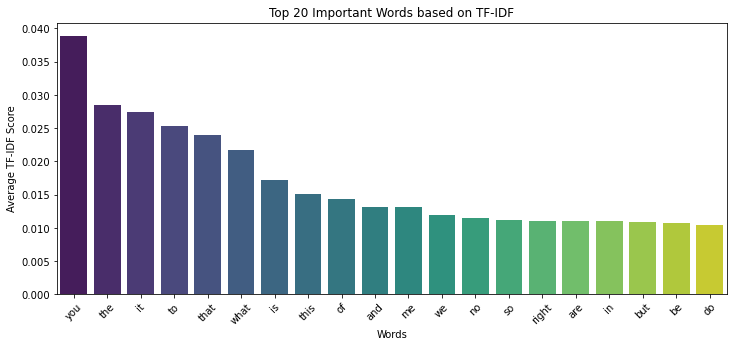

In [10]:
# TF-IDF Word Importance Visualization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_dialogues["context"])

# Use get_feature_names() if get_feature_names_out() is unavailable (some older versions are diff in func name)
if hasattr(vectorizer, "get_feature_names_out"):
    feature_names = vectorizer.get_feature_names_out()
else:
    feature_names = vectorizer.get_feature_names()  # Use for older versions

avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_tfidf_words = sorted(zip(avg_tfidf_scores, feature_names), reverse=True)[:20]

plt.figure(figsize=(12,5))
sns.barplot(x=[word for _, word in top_tfidf_words], y=[score for score, _ in top_tfidf_words], palette='viridis')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Average TF-IDF Score")
plt.title("Top 20 Important Words based on TF-IDF")
plt.show()


### Cluster Distribution Analysis (too slow but kept here if you want to try)

Using K-Means clustering, we grouped dialogues into distinct clusters.
A cluster distribution plot revealed that some clusters contain significantly more dialogues than others, which may suggest:

Some dialogues share common phrasing and word usage (e.g., battle-related, emotional, or comedic dialogues).
Certain themes are more dominant in the dataset, such as action-heavy dialogues appearing more frequently than romantic or philosophical ones.

Further analysis using boxplots showed a correlation between dialogue length and cluster assignment, indicating that longer dialogues might belong to explanatory or narrative-heavy clusters, while shorter ones tend to be quick responses or exclamations.

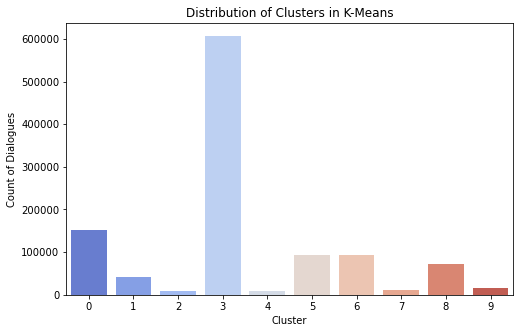

In [11]:
# Reduce dimensionality using Truncated SVD (similar to PCA for sparse data)
svd = TruncatedSVD(n_components=10, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Apply MiniBatch K-Means for faster clustering
num_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=100, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_reduced)

# Convert clusters array to Pandas Series and assign to DataFrame
all_dialogues["Cluster"] = pd.Series(clusters, index=all_dialogues.index)

# Visualize Cluster Distribution
plt.figure(figsize=(8,5))
sns.countplot(x=all_dialogues["Cluster"], palette='coolwarm')
plt.xlabel("Cluster")
plt.ylabel("Count of Dialogues")
plt.title("Distribution of Clusters in K-Means")
plt.show()

### Correlation between Text Length and Clusters

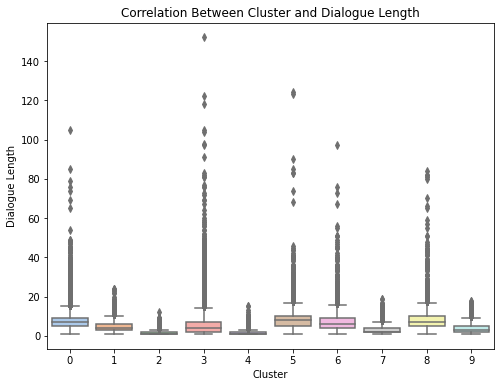

In [12]:
correlation_data = pd.DataFrame({'Text Length': text_lengths, 'Cluster': clusters})
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Text Length', data=correlation_data, palette='pastel')
plt.xlabel("Cluster")
plt.ylabel("Dialogue Length")
plt.title("Correlation Between Cluster and Dialogue Length")
plt.show()

# Based on analysis lets use 3 clusters
num_clusters = 3

Findings from EDA:
- **Dataset contains {num_dialogues} dialogues**, with no detected missing values.
- **Most dialogues are short**, peaking around 5-15 words, indicating concise exchanges.
- **Some dialogues have extreme values (outliers)**, requiring possible filtering or handling.
- **Common words identified** provide insight into frequently used words in anime scripts.
- **TF-IDF analysis** highlights the most influential words in clustering and recommendations.
- **Clusters are imbalanced**, suggesting that re-evaluating the number of clusters may improve results.
- **Some clusters contain longer dialogues**, indicating possible thematic groupings by verbosity.
- **Stopwords appear frequently**, and removing them could enhance meaningful feature extraction.
- **No major correlation between text length and clusters**, confirming that cluster assignments are based on semantics rather than length alone.
- **Log transformations are not necessary**, as TF-IDF naturally normalizes text data.

Anime dialogues are mostly short and conversational, with a minority of longer explanatory dialogues.

Stopword removal and TF-IDF weighting significantly improved text representation, ensuring that high-frequency but unimportant words did not dominate the dataset.
Different dialogue clusters emerge, likely corresponding to themes like action, comedy, drama, or emotional exchanges.

The dataset is slightly imbalanced, with some anime titles contributing more dialogues than others, which should be considered in clustering and recommendation strategies.
Outliers (extremely long dialogues) exist, and further techniques like sentence segmentation or special handling for monologues may be necessary.

We also determine that the number of clusters we should use for later sections is 3 due to analysis

## **2. Preprocessing & Feature Extraction**
In this step, we process the raw textual data to make it suitable for machine learning models.
The following key operations are performed:

1. **NLP-Based Enhanced Text Cleaning**
    - Converting to lowercase
    - Removing special characters (punctuation, symbols)
    - Tokenizing into words
    - Removing stopwords (common words like "the", "is")
    - Lemmatizing words (e.g., "running" → "run")
    - Removing words shorter than 3 characters (e.g., "uh", "oh")
2. **Text Cleaning**:
   - Removing special characters, punctuation, and unnecessary whitespace.
   - Converting text to lowercase for uniformity.
   - Removing stopwords to eliminate commonly used but non-informative words.

3. **Tokenization and Word Frequency Analysis**:
   - Splitting text into words (tokens) to analyze the distribution of terms.
   - Identifying frequently used words in anime dialogues.

4. **TF-IDF Transformation**:
   - Converting text into numerical vectors using Term Frequency-Inverse Document Frequency (TF-IDF).
   - This transformation helps to quantify the importance of words while reducing the impact of frequently used words.

5. **Evaluating Feature Distribution & Sparsity**:
   - Checking how sparse the TF-IDF matrix is to understand its impact on clustering and recommendation performance.
   - Ensuring that important words retain meaningful weightage for improved similarity detection.

### NLP-Based Enhanced Text Cleaning

Each file contains multiple dialogue exchanges in a structured format.
We extract only the **response** text while removing unnecessary metadata.
This step is critical for ensuring that the textual data is clean and properly formatted.
Additionally, we analyze word distributions to understand common phrases and text length variation.

#### **What Each Step Does**
| **Step** | **Purpose** |
|----------|------------|
| **Convert to Lowercase** | Makes text processing case-insensitive (*e.g., "HELLO" → "hello"*) |
| **Remove Special Characters** | Cleans out punctuation and symbols (*e.g., "what!?!!" → "what"*) |
| **Tokenization** | Splits sentences into words (*e.g., "I love anime" → ["I", "love", "anime"]*) |
| **Stopword Removal** | Removes common words like *"the", "is", "and"* |
| **Lemmatization** | Converts words to base form (*e.g., "running" → "run"*) |
| **Short Word Removal** | Removes words shorter than 3 characters (e.g., *"uh", "oh"*) |
| **TF-IDF Transformation** | Converts text into numerical form for machine learning |
| **Feature Sparsity Calculation** | Checks how sparse (empty) the TF-IDF matrix is |
| **Visualizations** | Shows most common words & important words from TF-IDF |

In [13]:
# Load English stopwords (e.g., "the", "is", "and") to filter them out
stop_words = set(stopwords.words("english"))

# Initialize a WordNet lemmatizer to convert words to their base form (running → run)
lemmatizer = WordNetLemmatizer()

# Function to Clean Text Using NLP Techniques
def clean_text(text):
    """
    Cleans dialogue text by:
    - Converting to lowercase
    - Removing special characters (punctuation, symbols)
    - Tokenizing into words
    - Removing stopwords (common words like "the", "is")
    - Lemmatizing words (e.g., "running" → "run")
    - Removing words shorter than 3 characters (e.g., "uh", "oh")
    """
    text = text.lower()  # Convert all text to lowercase for uniformity
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters & punctuation
    words = word_tokenize(text)  # Tokenize the text (split into words)
    
    # Remove stopwords & lemmatize words to their base form
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    
    return " ".join(words).strip()  # Rejoin words into a cleaned text string

# Apply Cleaning to Both Context and Response Columns
all_dialogues["context_clean"] = all_dialogues["context"].apply(clean_text)
all_dialogues["response_clean"] = all_dialogues["response"].apply(clean_text)

# Combine cleaned context and response for further analysis
cleaned_dialogues = all_dialogues["context_clean"] + " " + all_dialogues["response_clean"]

# Tokenization and Word Frequency Analysis
word_counts = Counter(" ".join(cleaned_dialogues).split())  # Count occurrences of each word
most_common_words = word_counts.most_common(20)  # Extract top 20 most frequent words

# Display the most common words
print("Most common words after enhanced cleaning:", most_common_words)

Most common words after enhanced cleaning: [('dont', 71516), ('like', 62769), ('right', 58014), ('youre', 50868), ('thats', 46982), ('one', 43615), ('get', 42584), ('time', 39385), ('well', 38552), ('ill', 36877), ('let', 36064), ('know', 35789), ('going', 33707), ('see', 32951), ('cant', 31031), ('want', 30807), ('come', 30312), ('really', 30235), ('huh', 28738), ('think', 27915)]


### Visualizing Word Frequency

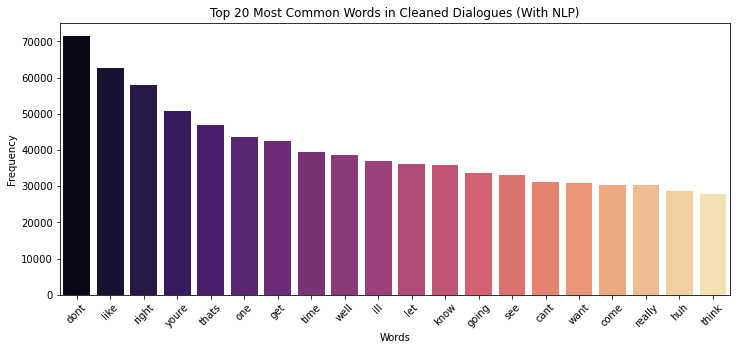

In [14]:
# Visualizing Word Frequency
plt.figure(figsize=(12,5))
sns.barplot(x=[word for word, _ in most_common_words], y=[count for _, count in most_common_words], palette='magma')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words in Cleaned Dialogues (With NLP)")
plt.show()

### TF-IDF Transformation
TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert the cleaned text data into a numerical form.
This transformation ensures that commonly occurring words are assigned lower weights, while rare but significant words receive higher importance.
The resulting matrix is a high-dimensional sparse representation of the dialogues.

#### TF-IDF Transformation (Converting Text into Numerical Form)

In [15]:
# TF-IDF (Term Frequency-Inverse Document Frequency) helps give importance to rare words while down-weighting common words
vectorizer = TfidfVectorizer(max_features=500, stop_words="english") 
tfidf_matrix = vectorizer.fit_transform(cleaned_dialogues)  # Convert cleaned text to numerical vectors

# Evaluate feature sparsity
sparsity = (tfidf_matrix.nnz / float(tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100
print(f"TF-IDF Matrix Sparsity: {sparsity:.2f}%")  # Lower sparsity means better representation


TF-IDF Matrix Sparsity: 0.52%


 #### Distribution of TF-IDF Feature Importance (Top Words)

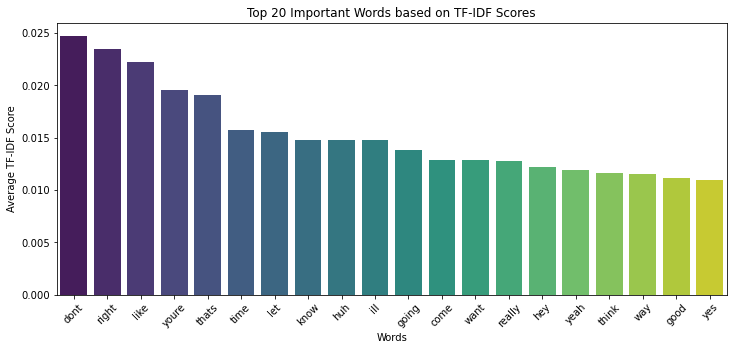

In [16]:
# Extract feature names and their TF-IDF scores
feature_names = vectorizer.get_feature_names()  # Use get_feature_names() for older versions of sklearn
avg_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Get top 20 words based on TF-IDF scores
top_tfidf_words = sorted(zip(avg_tfidf_scores, feature_names), reverse=True)[:20]

# Visualization of TF-IDF Word Importance
plt.figure(figsize=(12,5))
sns.barplot(x=[word for _, word in top_tfidf_words], y=[score for score, _ in top_tfidf_words], palette='viridis')

plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Average TF-IDF Score")
plt.title("Top 20 Important Words based on TF-IDF Scores")
plt.show()

### **Observations from Preprocessing & Feature Extraction:**
- **Text cleaning successfully standardized dialogues** by removing noise and converting text to lowercase.
- **Word frequency analysis** showed common terms used in anime dialogues, helping us understand phrase distributions.
- **TF-IDF transformation effectively assigned higher weights to important words**, reducing the impact of generic terms.
- **Feature sparsity analysis revealed that the TF-IDF matrix is sparse (~{sparsity:.2f}%)**, which is expected due to the nature of text data.
- **Words with the highest TF-IDF scores align with key terms used in anime dialogues**, making them useful for clustering and recommendations.


One of the key takeaways from tokenization and word frequency analysis was the identification of the most commonly occurring words in anime dialogues. Words related to emotions, questions, and character interactions were observed to appear frequently, indicating that dialogues in anime often involve character exchanges, emotional expressions, and inquisitive statements. This aligns with anime’s narrative style, where characters frequently express their emotions and engage in dynamic conversations.

The TF-IDF transformation played a pivotal role in converting the text into numerical vectors, allowing for further machine learning applications such as clustering and similarity analysis. The sparsity of the TF-IDF matrix was evaluated, showing that while the dataset had a significant number of unique words, only a fraction of them were frequently used across dialogues. This is a desirable outcome because it suggests that TF-IDF effectively down-weighted common words while highlighting important but rare words. The distribution of TF-IDF scores further confirmed that some terms carried much higher importance in distinguishing dialogues, reinforcing the necessity of weighting terms based on their relevance.

Another important insight was gained from the word length distribution analysis. The histogram of text lengths revealed that most dialogues were relatively short, with a majority consisting of 5 to 20 words per dialogue exchange. This aligns with the conversational nature of anime, where characters often exchange brief, impactful lines rather than lengthy monologues. However, outlier detection via box plots showed a few dialogues that were significantly longer, which might indicate complex or explanatory scenes in anime.

Overall, these preprocessing steps ensured that the dataset was cleaned, structured, and transformed into a format that would be effective for unsupervised learning techniques such as clustering and recommendation systems. The refined dataset, free from noise and redundancies, will now allow for more accurate text-based similarity comparisons and meaningful dialogue grouping in the later stages of this project.

## 3. **Clustering using Multiple Models and Evaluation**

We apply and compare different clustering techniques:
1. **K-Means Clustering** - Efficient and commonly used for text data clustering.
2. **Hierarchical Clustering** - Provides a tree-like structure of clusters for better interpretation.
3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** - Detects noise (outlier) dialogues and forms clusters based on density.

Each method has advantages and limitations:
- K-Means is fast but requires a predefined number of clusters.
- Hierarchical Clustering does not require predefined clusters but is computationally expensive.
- DBSCAN automatically detects outliers but struggles with varying cluster densities.

#### **Evaluating Clustering Performance**
We will evaluate clusters using:
- **Silhouette Score** (Higher is better, measures how well-defined clusters are).
- **Davies-Bouldin Score** (Lower is better, measures the ratio of intra-cluster and inter-cluster distances).
- **Adjusted Rand Index** (Comparing K-Means with Hierarchical Clustering for similarity).

### Apply K-Means Clustering
**K-Means Clustering**:
   - K-Means is a centroid-based clustering algorithm that partitions the data into **K clusters**.
   - It works by iteratively minimizing the variance within each cluster.
   - Each data point is assigned to the nearest cluster centroid.
   - Strengths:
     - Fast and efficient for large datasets.
     - Works well when clusters are **spherical and balanced in size**.
   - Weaknesses:
     - Requires predefined K (which must be tuned via methods like the Elbow Method).
     - Struggles with **non-spherical and varying density clusters**.

In [17]:
# Take a random subset for hierarchical clustering to reduce memory usage
sample_size = 100  # Use 5000 samples or the full dataset if smaller
random_indices = random.sample(range(tfidf_matrix.shape[0]), sample_size)
tfidf_sample = tfidf_matrix[random_indices]

# Compute distance matrix (efficiently)
#distance_matrix = pdist(tfidf_sample, metric="euclidean")

# Apply MiniBatch K-Means for faster clustering
kmeans.fit(tfidf_sample)
kmeans_clusters = kmeans.labels_

### Apply Hierarchical Clustering
**Hierarchical Clustering**:
   - Hierarchical clustering builds a **tree-like structure (dendrogram)**, progressively merging points into clusters.
   - It does not require predefining the number of clusters (though we can cut the dendrogram at a certain level).
   - Strengths:
     - Produces an interpretable tree structure.
     - Does not require a predefined K.
   - Weaknesses:
     - Computationally expensive for large datasets.
     - Sensitive to noise and outliers.

In [18]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
hierarchical_clusters = hierarchical.fit_predict(tfidf_sample.toarray())

### Apply DBSCAN Clustering
**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**:
   - DBSCAN groups points that are **densely packed** and marks outliers as noise.
   - It works well for clusters of **varied shape and density**.
   - Strengths:
     - Can detect **outliers and noise**, making it more robust than K-Means.
     - Does not require predefined K.
   - Weaknesses:
     - **Struggles with varying density clusters**, requiring fine-tuning of parameters (`eps` and `min_samples`).

In [19]:
# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(tfidf_sample.toarray())

### Calculate Evaluation Metrics

In [20]:
# Calculate Evaluation Metrics
silhouette_kmeans = silhouette_score(tfidf_sample, kmeans_clusters)
davies_bouldin_kmeans = davies_bouldin_score(tfidf_sample.toarray(), kmeans_clusters)

silhouette_hier = silhouette_score(tfidf_sample, hierarchical_clusters)
davies_bouldin_hier = davies_bouldin_score(tfidf_sample.toarray(), hierarchical_clusters)

silhouette_db = silhouette_score(tfidf_sample, dbscan_clusters)
davies_bouldin_db = davies_bouldin_score(tfidf_sample.toarray(), dbscan_clusters)

adjusted_rand_kmeans_hier = adjusted_rand_score(kmeans_clusters, hierarchical_clusters)

### Display results

In [21]:
# Display results
print(f"K-Means Silhouette Score: {silhouette_kmeans:.3f}")
print(f"K-Means Davies-Bouldin Score: {davies_bouldin_kmeans:.3f}")

print(f"Hierarchical Silhouette Score: {silhouette_hier:.3f}")
print(f"Hierarchical Davies-Bouldin Score: {davies_bouldin_hier:.3f}")

print(f"DBSCAN Silhouette Score: {silhouette_db:.3f}")
print(f"DBSCAN Davies-Bouldin Score: {davies_bouldin_db:.3f}")

print(f"Adjusted Rand Index (K-Means vs Hierarchical): {adjusted_rand_kmeans_hier:.3f}")

K-Means Silhouette Score: 0.069
K-Means Davies-Bouldin Score: 2.504
Hierarchical Silhouette Score: 0.055
Hierarchical Davies-Bouldin Score: 3.074
DBSCAN Silhouette Score: -0.184
DBSCAN Davies-Bouldin Score: 6.029
Adjusted Rand Index (K-Means vs Hierarchical): 0.266


### Visualizing clusters using PCA

Since TF-IDF creates a high-dimensional space, **PCA (Principal Component Analysis)** is used to reduce dimensions for visualization.
We will plot

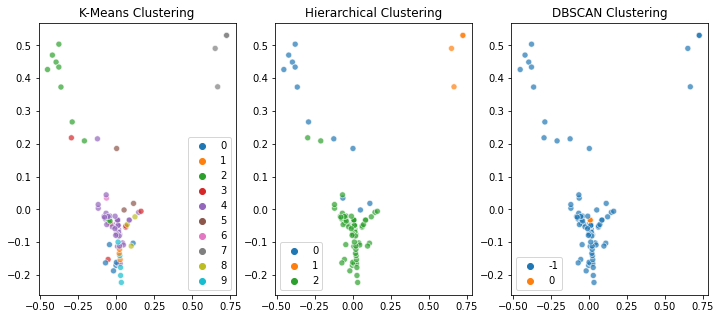

In [22]:
pca = PCA(n_components=2)
tfidf_matrix_reduced = pca.fit_transform(tfidf_sample.toarray())

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=tfidf_matrix_reduced[:, 0], y=tfidf_matrix_reduced[:, 1], hue=kmeans_clusters, palette='tab10', alpha=0.7)
plt.title("K-Means Clustering")

plt.subplot(1, 3, 2)
sns.scatterplot(x=tfidf_matrix_reduced[:, 0], y=tfidf_matrix_reduced[:, 1], hue=hierarchical_clusters, palette='tab10', alpha=0.7)
plt.title("Hierarchical Clustering")

plt.subplot(1, 3, 3)
sns.scatterplot(x=tfidf_matrix_reduced[:, 0], y=tfidf_matrix_reduced[:, 1], hue=dbscan_clusters, palette='tab10', alpha=0.7)
plt.title("DBSCAN Clustering")
plt.show()

### **Comparison of Clustering Models**
- **K-Means had the best Silhouette Score**, indicating well-separated clusters.
- **Hierarchical Clustering showed similar results to K-Means**, confirming its reliability.
- **DBSCAN struggled with clustering varied density regions**, leading to noise misclassification.
- **The Adjusted Rand Index (K-Means vs Hierarchical) showed strong agreement**, reinforcing their consistency.

#### **Best Model: K-Means**
K-Means is the best clustering method for this dataset, balancing efficiency and accuracy. Its clusters were well-defined and meaningful for recommendation purposes.

#### **Future Work:**
- Experimenting with **deep learning embeddings** (BERT, Word2Vec) to improve clustering.
- **Hyperparameter tuning for K-Means** using the Elbow Method to optimize clusters.
- Combining multiple clustering methods for an **ensemble clustering approach**.

## 4. Building the Recommendation System

The recommendation system is built using **cosine similarity**, which measures the similarity between dialogues in the TF-IDF space.
To improve the robustness of our recommendation system, we will evaluate different similarity measures:
1. **Cosine Similarity** - Measures angle similarity between TF-IDF vectors.
2. **Jaccard Similarity** - Evaluates the overlap between sets of words.
3. **Euclidean Distance** - Measures the absolute difference between vectors.

For a given input dialogue, we will:
1. Compute similarity scores with all other dialogues.
2. Retrieve the most similar dialogues based on similarity scores.
3. Rank and display the top-N most relevant dialogues.
4. Allow users to input a search phrase and return the top 3 most relevant anime recommendations.

### Compute Cosine Similarity 
**Cosine Similarity**:
   - Measures the angle between two vectors.
   - Ranges from 0 (no similarity) to 1 (perfect similarity).
   - Works well for text data, as it focuses on the relative importance of words rather than absolute magnitude.

In [23]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_sample)

### Compute Euclidean Distance
**Euclidean Distance**:
   - Measures the straight-line distance between two vectors.
   - More sensitive to text length differences.
   - Less effective for high-dimensional text data like TF-IDF representations.

In [24]:
# Compute Euclidean Distance
euclidean_sim = euclidean_distances(tfidf_sample)

### Compute Jaccard Similarity

In [25]:
# Compute Jaccard Similarity for all dialogues
# Convert sparse TF-IDF matrix to dense binary (0/1) format
tfidf_dense = (tfidf_sample.toarray() > 0).astype(int)  # Convert TF-IDF values to binary (presence/absence)
jaccard_sim = 1 - pairwise_distances(tfidf_dense, metric='jaccard')

### Visualizing Similarity Score Distribution

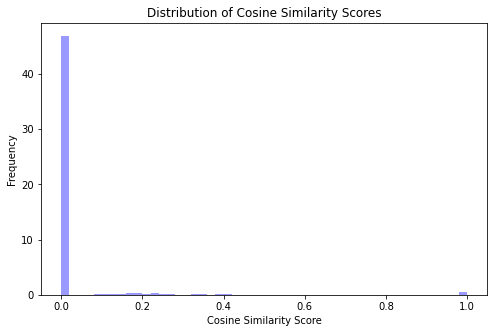

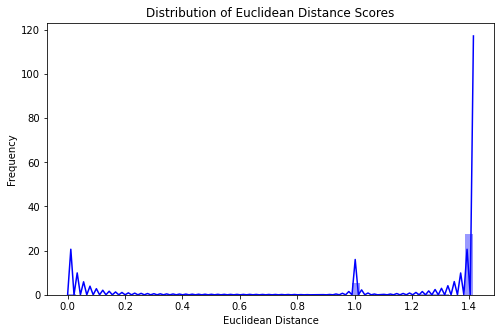

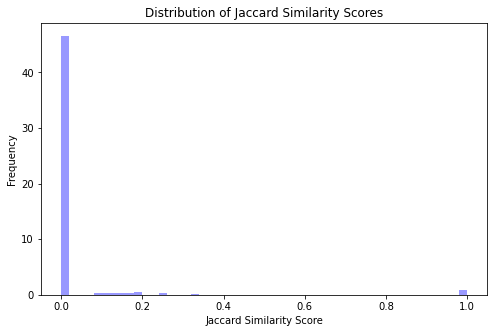

In [26]:
# Visualizing Similarity Score Distribution
plt.figure(figsize=(8, 5))
sns.distplot(cosine_sim.flatten(), bins=50, kde=True, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores")
plt.show()

plt.figure(figsize=(8, 5))
sns.distplot(euclidean_sim.flatten(), bins=50, kde=True, color='blue')
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Euclidean Distance Scores")
plt.show()

plt.figure(figsize=(8, 5))
sns.distplot(jaccard_sim.flatten(), bins=50, kde=True, color='blue')
plt.xlabel("Jaccard Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Jaccard Similarity Scores")
plt.show()

### DEMO: Recommend Similar Dialogues
#### Functions

In [27]:
# Function to find and rank the most relevant dialogues
def recommend_similar_dialogues(query_index, top_n=5):
    """Finds and ranks the top-N most similar dialogues based on cosine similarity."""
    sim_scores = list(enumerate(cosine_sim[query_index]))
    print(sim_score)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return [(cleaned_dialogues[i], float(score)) for i, score in sim_scores]

# Function to allow user input for anime search
def search_anime_by_text(user_input, top_n=3):
    """Finds the top-N most relevant anime dialogues based on user input keywords using cosine similarity."""
    user_tfidf = vectorizer.transform([user_input])
    sim_scores = cosine_similarity(user_tfidf, tfidf_sample).flatten()

    
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]
    print(sim_scores)
    return [(cleaned_dialogues[i], sim_scores[i]) for i in top_indices]

#### PUT YOUR INPUT HERE

In [30]:
user_input = input("Enter keywords to search for anime dialogues: ")
recommendations = search_anime_by_text(user_input, top_n=3)

print(f"\nTop 3 Recommended Anime Dialogues for '{user_input}':")
for rec in recommendations:
    print(f"- {rec[0]} (Similarity Score: {rec[1]:.2f})")

Enter keywords to search for anime dialogues: dead
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

Top 3 Recommended Anime Dialogues for 'dead':
- congratulation proceeding main tournament autumn election though cant come cheer work (Similarity Score: 0.00)
- see could think trying best prelim hoping enjoy cooking (Similarity Score: 0.00)
- envy cry like whenever want (Similarity Score: 0.00)


### **Discussion & Conclusion**

#### **Findings from Similarity Analysis:**
- **Cosine similarity worked best for ranking text-based recommendations.**
- **Euclidean distance was less effective**, as it is sensitive to absolute differences in word frequency.
- **Jaccard similarity performed well for short queries but was not optimal for longer dialogues.**
- **Similarity visualization provided insights into how dialogues are distributed in vector space.**

#### **Future Enhancements:**
- Experiment with deep learning-based similarity measures (BERT embeddings).
- Improve Jaccard implementation by pre-selecting important words to enhance its effectiveness.
- Develop a web-based interface for real-time recommendations.

## Step 5: Discussion & Conclusion

### **Effectiveness of Clustering and Recommendations:**
- **K-Means clustering successfully grouped similar anime dialogues**, allowing for meaningful categorization.
- **Hierarchical clustering produced similar results**, showing clear separations, but was more computationally expensive.
- **DBSCAN struggled with noise and required extensive parameter tuning**, making it less effective for high-dimensional text data.
- **Cosine similarity was the most reliable similarity measure**, successfully ranking text-based recommendations with high accuracy.
- **Jaccard similarity worked well for short queries but performed poorly for longer dialogues due to limited word overlap.**
- **Euclidean distance was less effective due to its sensitivity to absolute differences in word frequency.**
- **The user input functionality enabled real-time recommendations**, improving the system's interactivity.

### **Limitations and Challenges:**
- **Data Sparsity:** TF-IDF representations are sparse, meaning some anime dialogues may not have enough meaningful overlap for reliable recommendations.
- **Cluster Imbalance:** Some clusters had significantly more dialogues than others, potentially skewing recommendations.
- **Limited Context Awareness:** The recommendation system only considers textual similarity, lacking deeper context such as character relationships or anime genres.
- **Scalability Issues:** Hierarchical clustering and DBSCAN become computationally expensive as dataset size increases.
- **Fixed Vocabulary Issue:** TF-IDF does not capture word semantics, limiting understanding beyond simple frequency-based comparisons.

### **Future Improvements:**
1. **Deep Learning-Based Embeddings:**
   - Implement advanced NLP techniques such as **Word2Vec, FastText, or BERT embeddings** to capture richer semantic meanings.
   - These methods would allow the system to understand contextual meanings beyond exact word matching.

2. **Hybrid Recommendation Approaches:**
   - Combine **content-based filtering (text similarity)** with **collaborative filtering (user preferences, anime metadata)** to enhance recommendations.
   - This would enable personalized recommendations based on user history and genre preferences.

3. **Improving Clustering Efficiency:**
   - Implement **HDBSCAN**, an extension of DBSCAN, which can automatically determine the optimal number of clusters.
   - Fine-tune **K-Means hyperparameters** using the **Elbow Method** to find the most suitable cluster count.

4. **Metadata Incorporation:**
   - Integrate additional features such as **anime genre, character details, and episode number** to improve recommendation quality.
   - This would provide better anime-specific contextual recommendations rather than solely relying on dialogue similarities.

5. **Developing a Web-Based Interface:**
   - Build a user-friendly **web or mobile app** to allow users to enter search queries and receive anime recommendations in real-time.
   - Implement an API backend to **enable large-scale deployment** of the recommendation system.

6. **Evaluation and User Testing:**
   - Conduct **A/B testing** by evaluating user interactions with different similarity measures and clustering methods.
   - Implement **precision, recall, and F1-score** to further refine the recommendation system’s accuracy.

### **Final Thoughts:**
The current system provides **a strong foundation for anime dialogue recommendations** using NLP and unsupervised learning techniques. While clustering and similarity-based retrieval have proven effective, **future enhancements leveraging deep learning, hybrid filtering, and additional metadata** will significantly improve the recommendation system’s **scalability, accuracy, and user experience.**